# Analysis example and plotting tutorial

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import mcmm

import pyemma
from mcmm.example import generate_test_data


plt.rc('font', size=15)

Here, we define a function to add often used properties to a matplotlib axis object.

In [2]:
def format_square(ax):
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    
    ax.set_xticks([-2, -1, 0, 1, 2])
    ax.set_yticks([-2, -1, 0, 1, 2])
    ax.set_xlabel(r"$x$ / a.u.")
    ax.set_ylabel(r"$y$ / a.u.")
    ax.set_aspect('equal')

## Data generation

We start by calling the data generation function from the example module.

In [3]:
raw_data = generate_test_data()


`raw_data` is a list of 2D numpy ndarrays which we visualise as a scatter plot. You can also try to plot the $x$-/$y$-components as time series.

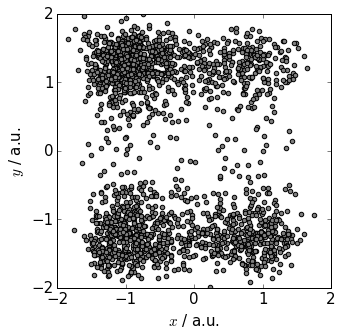

In [4]:
fig, ax = plt.subplots(figsize=(5, 5))
for rd in raw_data:
    ax.scatter(rd[::50, 0], rd[::50, 1], c='grey', s=20)
format_square(ax)
fig.tight_layout()

## Clustering and discretisation

This example uses `pyemma`, but your `mcmm` nodule must be able to to the same.

In [5]:
cluster = mcmm.clustering.cluster(raw_data)
centers = cluster.centers
dtrajs = cluster.disctrajectories
cluster2 = pyemma.coordinates.cluster_kmeans(data=raw_data, k=100, max_iter=100)
centers2 = cluster2.clustercenters
dtrajs2 = cluster2.dtrajs

12-07-16 13:36:31 pyemma.coordinates.clustering.kmeans.KmeansClustering[0] INFO     Cluster centers converged after 64 steps.


We extend our scatter plot of the raw data by adding the cluster centers.

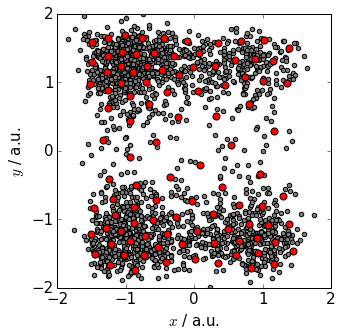

In [6]:
fig, ax = plt.subplots(figsize=(5, 5))
for rd in raw_data:
    ax.scatter(rd[::50, 0], rd[::50, 1], c='grey', s=20)
ax.scatter(centers[:, 0], centers[:, 1], c='red', s=50)
format_square(ax)
fig.tight_layout()

In [7]:
#print(type(dtrajs))
#print(dtrajs.shape)
#_dtrajs = [dtrajs[i, :] for i in range(dtrajs.shape[0])]
#print(type(_dtrajs))
#print(_dtrajs[0].dtype)
#plt.plot(_dtrajs[0])

## Estimation and timescales

This is where we start to estimate transition matrices. In order to find a good lagtime, we can estimate several transition matrices for different lagtimes and look at the timescales. Once they are converged, we might have found a suitable lagtime.

/home/mi/fmettberlin/mcmm-project/mcmm/msm.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  eigval[:,i]=lag.eigvalues[1:n+1]


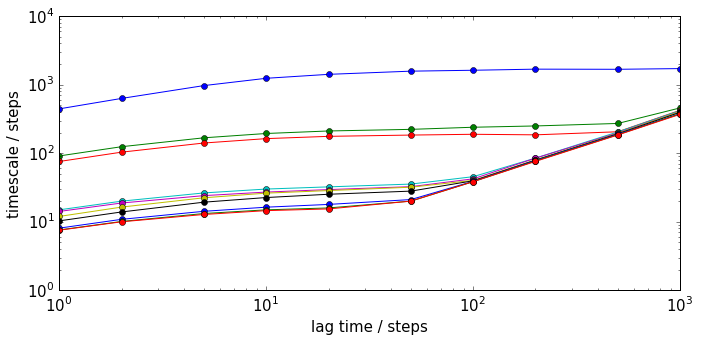

[array([84, 84, 68, ..., 83, 83, 83]), array([17, 34, 74, ..., 39, 84, 90]), array([54, 28,  7, ..., 45, 45, 29]), array([ 9, 47,  9, ..., 36, 52, 52]), array([47, 47, 47, ..., 84, 84, 84])]


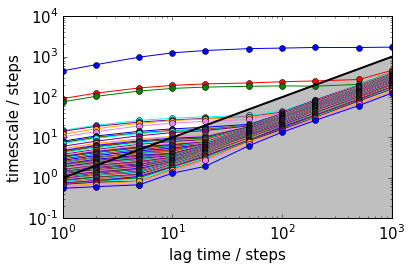

In [8]:
#dtrajs = np.random.randint(0,4,[5,20000])
ax = mcmm.msm.impliedTimescales(dtrajs,[1,2,5,10,20,50,100,200,500,1000])
print(dtrajs)
#ax.figure.tight_layout()


ax = pyemma.plots.plot_implied_timescales(
    pyemma.msm.its(dtrajs=dtrajs, lags=[1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]),
    xlog=True, marker='o')
ax.figure.tight_layout()

Now we have to decide on a lagtime and estimate the MSM. A further Chapman-Kolmogoroff test can tell us more about the suitability of the chosen lagtime.

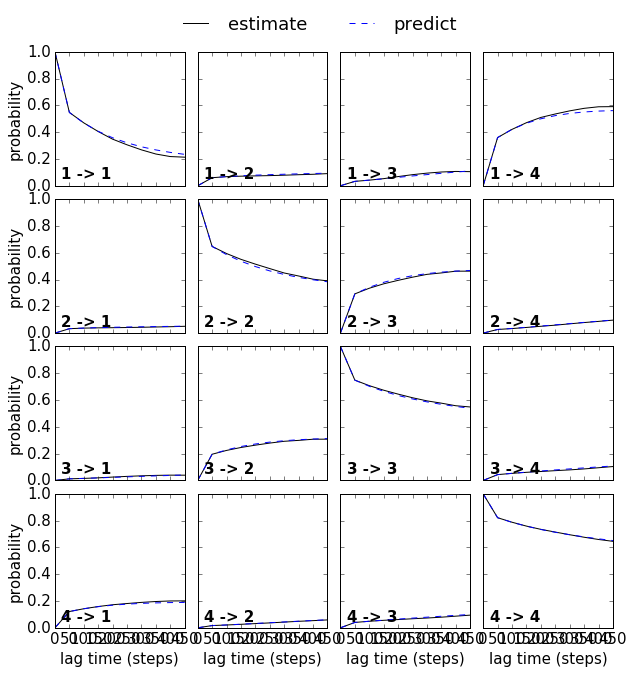

In [9]:
msm = pyemma.msm.estimate_markov_model(dtrajs=dtrajs, lag=50)

fig, axes = pyemma.plots.plot_cktest(msm.cktest(4))

## Analysis

Let's learn something about our system. We start by looking at the stationary distribution $\pi$, which can be visualised as a colored scatter plot of the cluster centers.

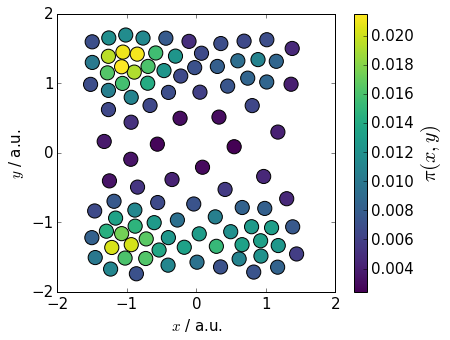

In [10]:
fig, ax = plt.subplots(figsize=(6.5, 5))
im = ax.scatter(centers[:, 0], centers[:, 1], c=msm.stationary_distribution, s=200, cmap=mpl.cm.viridis)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r"$\pi(x,y)$", fontsize=20)
format_square(ax)
fig.tight_layout()

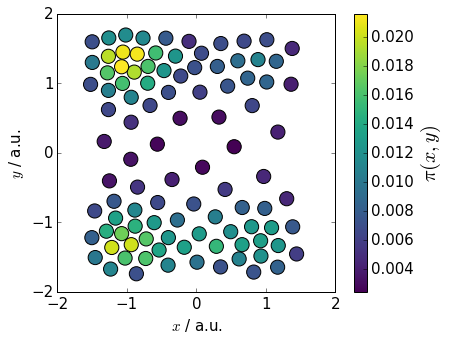

In [11]:
tau = 50
estimationObject = mcmm.estimation.estimate(cluster.disctrajectories,tau,cluster.numberCenters)

msmObject = mcmm.msm.MSM(estimationObject.transitionMatrix)


fig, ax = plt.subplots(figsize=(6.5, 5))
im = ax.scatter(centers[:, 0], centers[:, 1], c=msmObject.stationary, s=200, cmap=mpl.cm.viridis)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r"$\pi(x,y)$", fontsize=20)
format_square(ax)
fig.tight_layout()

In the same way, we can visualise, e.g., some of the right eigenvectors.

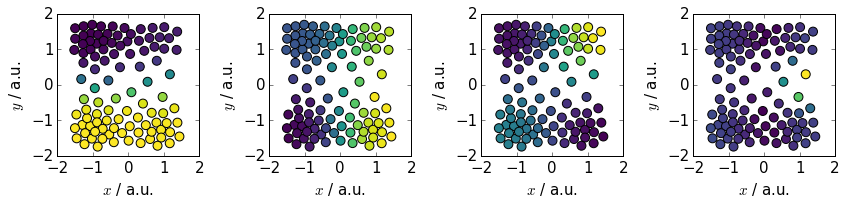

In [12]:
#rev = msm.eigenvectors_right(k=5)
rev = np.real(msmObject.righteigvectors)

#print(rev)

fig, axes = plt.subplots(1, 4, figsize=(12, 3.5))
for i, ax in enumerate(axes.flat):
    ax.scatter(centers[:, 0], centers[:, 1], s=80, c=rev[:, i+1], cmap=mpl.cm.viridis)
    format_square(ax)
fig.tight_layout()

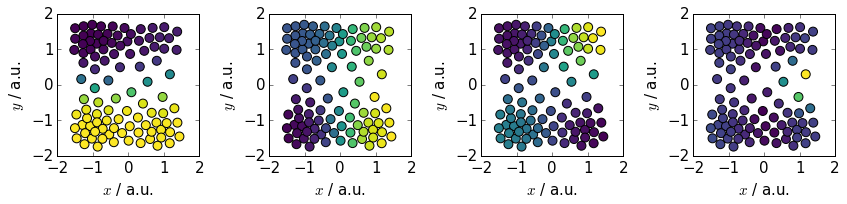

In [13]:
rev = msm.eigenvectors_right(k=5)


fig, axes = plt.subplots(1, 4, figsize=(12, 3.5))
for i, ax in enumerate(axes.flat):
    ax.scatter(centers[:, 0], centers[:, 1], s=80, c=rev[:, i+1], cmap=mpl.cm.viridis)
    format_square(ax)
fig.tight_layout()

Now it's useful to start coarse graining our system into metastable states with PCCA++. The assignments can, again, be visualised as a colored scatter plot.

In [14]:
msm.metastable_assignments

array([1, 1, 3, 2, 0, 0, 2, 3, 2, 3, 3, 1, 2, 2, 3, 3, 1, 0, 1, 1, 1, 1, 0,
       0, 3, 2, 2, 2, 3, 1, 2, 0, 2, 3, 0, 3, 2, 1, 0, 3, 1, 3, 3, 3, 3, 1,
       2, 3, 2, 1, 3, 1, 2, 1, 3, 1, 2, 2, 0, 2, 0, 2, 2, 3, 3, 3, 1, 0, 3,
       1, 2, 3, 3, 2, 0, 0, 3, 3, 3, 3, 1, 2, 2, 2, 3, 0, 3, 2, 1, 1, 0, 2,
       1, 1, 3, 2, 3, 2, 0, 3])

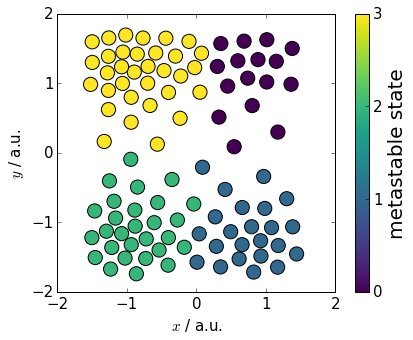

In [15]:
n_pcca_states = 4

#msm.pcca(n_pcca_states)
assign,c = msmObject.pcca(n_pcca_states)

fig, ax = plt.subplots(figsize=(6.5, 5))
im = ax.scatter(centers[:, 0], centers[:, 1], c=c, s=200, cmap=mpl.cm.viridis)
cbar = fig.colorbar(im, ax=ax)
cbar.set_ticks(np.arange(n_pcca_states))
cbar.set_label(r"metastable state", fontsize=20)
format_square(ax)
fig.tight_layout()

We compute the stationary probabilities of the metastable states and use this as new coloring for the scatter plot.

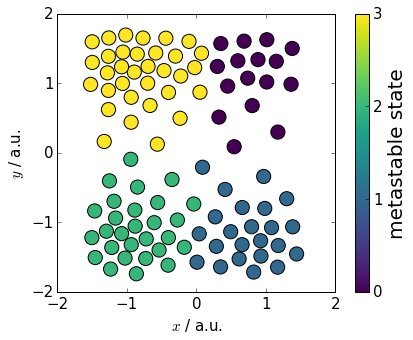

In [16]:
n_pcca_states = 4

msm.pcca(n_pcca_states)

fig, ax = plt.subplots(figsize=(6.5, 5))
im = ax.scatter(centers[:, 0], centers[:, 1], c=msm.metastable_assignments, s=200, cmap=mpl.cm.viridis)
cbar = fig.colorbar(im, ax=ax)
cbar.set_ticks(np.arange(n_pcca_states))
cbar.set_label(r"metastable state", fontsize=20)
format_square(ax)
fig.tight_layout()

[ 0.1065845   0.21883395  0.31510646  0.35947509]


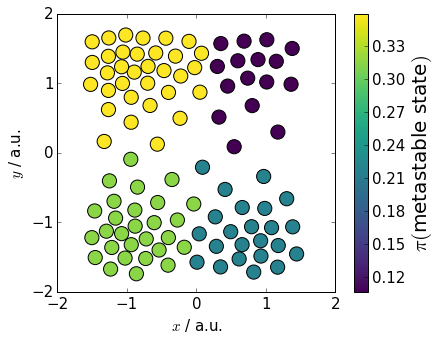

In [17]:
pi = np.array([msm.stationary_distribution[s].sum() for s in msm.metastable_sets])
pi_vec = pi[msm.metastable_assignments]

fig, ax = plt.subplots(figsize=(6.5, 5))
im = ax.scatter(centers[:, 0], centers[:, 1], c=pi_vec, s=200, cmap=mpl.cm.viridis)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r"$\pi($metastable state$)$", fontsize=20)
format_square(ax)
fig.tight_layout()

print (pi)

Finally, we compute mean first passage times (MFPTs) and draw a graph where the size of the nodes is proportional to the stationary probabilities of the metastable states and the thickness of the arrows indicates how fast a transition can occur on average. The actual MFPT values are used as labels for the arrows.

In [18]:
mfpt=msmObject.mfptTransM(tau)

mfpt

array([[     0.        ,   3774.47999148,   7083.95060721, ...,
          3170.24662544,  14514.02166745,   6722.85760517],
       [  3948.90628093,      0.        ,   7096.81256051, ...,
          3181.96991815,  14510.51896146,   6735.61000631],
       [  7750.44802189,   7588.88368575,      0.        , ...,
          5889.24100145,  14641.28730588,   3088.02647312],
       ..., 
       [  5132.17658904,   4969.4735923 ,   7184.67355036, ...,
             0.        ,  15171.54304502,   6817.06243285],
       [  5895.06121911,   5717.13222367,   5355.82944285, ...,
          4590.65263308,      0.        ,   5024.43463393],
       [  7813.29602955,   7651.62214124,   3511.96748281, ...,
          5945.57089363,  14733.83350665,      0.        ]])

In [19]:
metaT=msmObject.metaT(assign)
mfpt=mcmm.msm.mfptMeta(metaT,tau)

IndexError: index 16 is out of bounds for axis 0 with size 16

In [ ]:
np.shape(assign)[0]

In [ ]:
len(assign[3])

In [ ]:
mfpt2 = np.zeros(shape=(n_pcca_states, n_pcca_states))
for i, s1 in enumerate(msm.metastable_sets):
    for j, s2 in enumerate(msm.metastable_sets):
        if s1 is s2: continue
        mfpt2[i, j] = msm.mfpt(s1, s2)
mfpt2

In [ ]:
mfpt=msmObject.mfptTransM(tau)
#mfpt = np.zeros(shape=(n_pcca_states, n_pcca_states))
#for i, s1 in enumerate(msm.metastable_sets):
#    for j, s2 in enumerate(msm.metastable_sets):
#        if s1 is s2: continue
#        mfpt[i, j] = msm.mfpt(s1, s2)

arrow_weights = mfpt.copy()
nz = mfpt.nonzero()
arrow_weights[nz] = 1.0 / arrow_weights[nz]

fig, pos = pyemma.plots.plot_network(
    arrow_weights, xpos=[1, 1.5, 4, 4.5], state_sizes=pi,
    arrow_labels=mfpt, arrow_label_format="%.0f", arrow_scale=2.0)
fig.tight_layout()